In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime

In [2]:
R = 1
A = 1
B = 1
nx = 200
dx = (2 * R) / (nx + 1)
T = 4.827 * A

config = {
    'domain': {
        'minExtent': -3 * R,
        'maxExtent': 3 * R,
        'dim': 2,
        'periodic': False
    },
    'particle': {
        'nx': nx,
        'dx': dx,
    },
    'compute':{
        'device': 'cuda'
    },
    'fluid':{
        'cs' : 15 * R * A
    },
    'shifting':{
        'scheme': 'deltaPlus',
        'maxIterations': 1,
        'threshold': 0.05,
        'surfaceScaling' : 1.0,
        'freeSurface': True
    },
    'gravity':{
        'active': True,
        'magnitude': B,
        'gravityMode':'potentialField'
    }
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

# display(config)

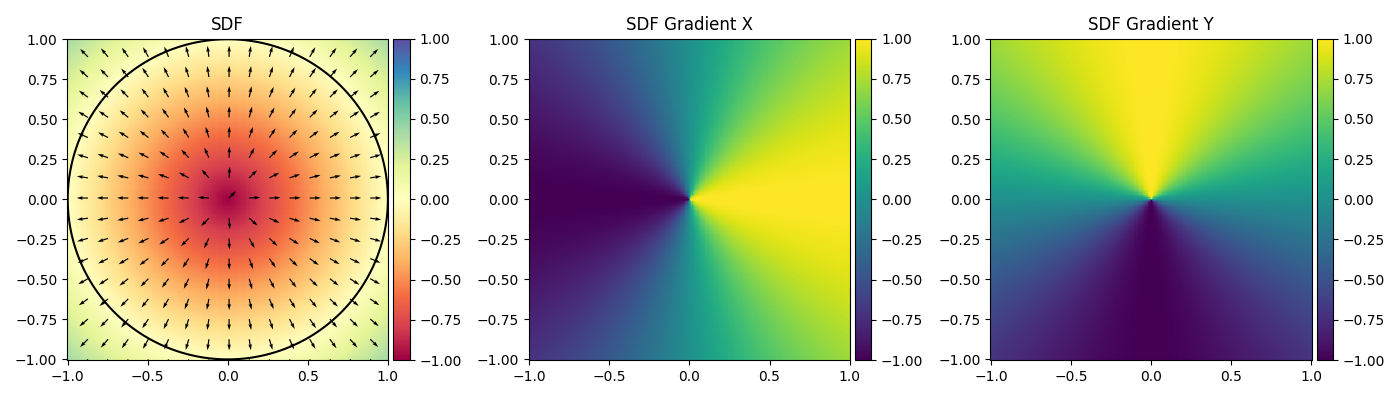

In [3]:
from diffSPH.v2.sdf import getSDF, operatorDict
from diffSPH.v2.plotting import *
ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('circle')['function'](points, R)
sdf = sphere_a
plotSDF(sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

In [4]:
particleState, mask = sampleParticles(config, sdfs = [sdf], 
    minExtent = [-R + config['particle']['dx'] / 2, -R + config['particle']['dx'] / 2], 
    maxExtent = [ R - config['particle']['dx'] / 2,  R - config['particle']['dx'] / 2])

In [5]:
printState(particleState)

state[numParticles            ]:      31700	[<class 'int'>]
state[timestep                ]:          0	[<class 'int'>]
state[time                    ]:        0.0	[<class 'float'>]
state[dt                      ]:      0.001	[<class 'float'>]
state[fluidPositions          ]: min: -9.900e-01, max: +9.900e-01, median: -4.975e-03 [torch.Size([31700, 2])	@ cuda:0	x torch.float32	]
state[fluidAreas              ]: min: +9.901e-05, max: +9.901e-05, median: +9.901e-05 [torch.Size([31700])	@ cuda:0	x torch.float32	]
state[fluidPressures          ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([31700])	@ cuda:0	x torch.float32	]
state[fluidDivergence         ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([31700])	@ cuda:0	x torch.float32	]
state[fluidMasses             ]: min: +9.901e-02, max: +9.901e-02, median: +9.901e-02 [torch.Size([31700])	@ cuda:0	x torch.float32	]
state[fluidSupports           ]: min: +3.776e-02, max: +3.776e-02, median: +3.776e-

In [6]:
perennialState = copy.deepcopy(particleState)

priorState = None
config['diffusion']['velocityScheme'] = 'deltaSPH_inviscid'
config['diffusion']['nu'] = 0.01
config['diffusion']['alpha'] = 0.01

perennialState['fluidVelocities'][:,0] =  A * perennialState['fluidPositions'][:,0]
perennialState['fluidVelocities'][:,1] = -A * perennialState['fluidPositions'][:,1]
perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)

In [7]:
printState(perennialState)

state[numParticles            ]:      31700	[<class 'int'>]
state[timestep                ]:          0	[<class 'int'>]
state[time                    ]:        0.0	[<class 'float'>]
state[dt                      ]:      0.001	[<class 'float'>]
state[fluidPositions          ]: min: -9.900e-01, max: +9.900e-01, median: -4.975e-03 [torch.Size([31700, 2])	@ cuda:0	x torch.float32	]
state[fluidAreas              ]: min: +9.901e-05, max: +9.901e-05, median: +9.901e-05 [torch.Size([31700])	@ cuda:0	x torch.float32	]
state[fluidPressures          ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([31700])	@ cuda:0	x torch.float32	]
state[fluidDivergence         ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([31700])	@ cuda:0	x torch.float32	]
state[fluidMasses             ]: min: +9.901e-02, max: +9.901e-02, median: +9.901e-02 [torch.Size([31700])	@ cuda:0	x torch.float32	]
state[fluidSupports           ]: min: +3.776e-02, max: +3.776e-02, median: +3.776e-

In [8]:

from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationFluidState
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationFluidState
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity


def simulationStep(simulationState, config, diffusion = 'yes'):
    simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
    _, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])
    
    simulationState['fluidL'], _, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)
    simulationState['fluidGradRho^L'] = renormalizedDensityGradient(simulationState, config)
    # simulationState['fluidGradRho'] = sphOperationFluidState(simulationState, (simulationState['fluidDensities'], simulationState['fluidDensities']), operation = 'gradient', gradientMode='difference')
    
    simulationState['fluidDensityDiffusion'] = computeDensityDeltaTerm(simulationState, config)
    simulationState['fluidMomentumEquation'] = computeMomentumEquation(simulationState, config)

    simulationState['fluidVelocityDiffusion'] = computeViscosity(simulationState, config)
    simulationState['fluidPressures'] = computeEOS(simulationState, config)

    if config['deltaSPH']['pressureSwitch']:
        # simulationState['fluidNormals'], simulationState['fluidLambdas'] = computeNormalsMaronne(simulationState, config)
        simulationState['fluidFreeSurface']= detectFreeSurfaceBarecasco(simulationState, config)
        (i,j) = simulationState['fluidNeighborhood']['indices']
        numParticles = simulationState['numParticles']
        simulationState['fluidSurfaceMask'] = scatter_sum(simulationState['fluidFreeSurface'][j], i, dim = 0, dim_size = numParticles)
        simulationState['fluidPressureAccel'] = computePressureAccelSwitch(simulationState, config)
    else:
        simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config)

    simulationState['fluidDivergence'] = sphOperationFluidState(simulationState, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), 'divergence')

    simulationState['fluidGravityAccel'] = computeGravity(simulationState, config) #/ simulationState['fluidMasses'].unsqueeze(-1)

    dudt = simulationState['fluidPressureAccel'] + simulationState['fluidGravityAccel']
    drhodt = simulationState['fluidMomentumEquation']

    if diffusion == 'yes':
        dudt += simulationState['fluidVelocityDiffusion']
        drhodt += simulationState['fluidDensityDiffusion']
    elif diffusion == 'only':
        dudt = simulationState['fluidVelocityDiffusion']
        drhodt = simulationState['fluidDensityDiffusion']
    elif diffusion == 'no':
        pass
    
    return simulationState['fluidVelocities'].clone(), dudt, drhodt


In [9]:
display(config['diffusion'])

{'delta': 0.1,
 'densityScheme': 'deltaSPH',
 'velocityScheme': 'deltaSPH_inviscid',
 'nu': 0.01,
 'alpha': 0.01,
 'beta': 0.0,
 'pi-switch': False,
 'artificial-constant': 0.02,
 'eps': 1e-06}

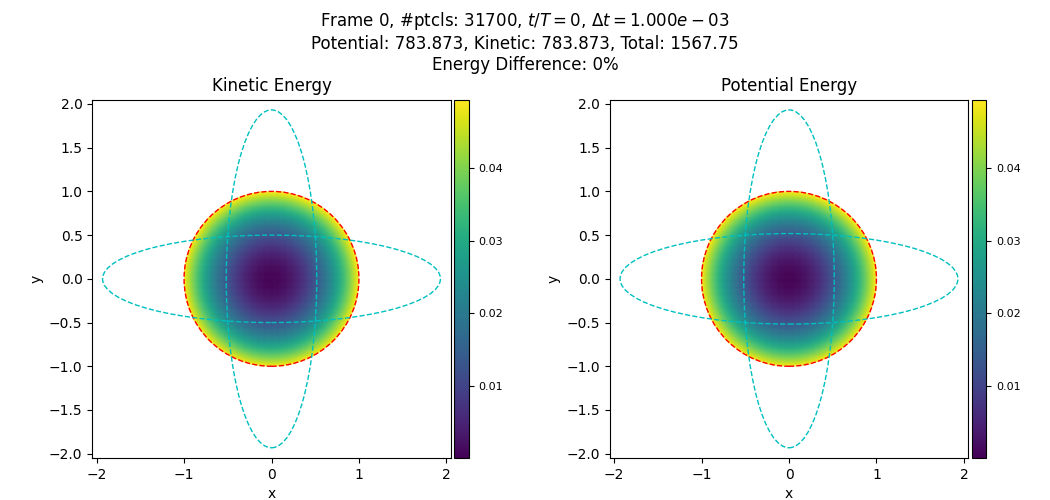

In [10]:
s = 1

fig, axis = plt.subplot_mosaic('''AB''', figsize=(10.5,5), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)
# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'$P/\rho\omega^2L^2$')

val = perennialState['fluidNumNeighbors']

initialVelocity = perennialState['fluidVelocities'].clone()
initialVelocity[:,0] =  A * particleState['fluidPositions'][:,0]
initialVelocity[:,1] = -A * particleState['fluidPositions'][:,1]

initialKineticEnergy = 0.5 * perennialState['fluidAreas'] * particleState['fluidDensities'] * torch.linalg.norm(initialVelocity, dim = -1)**2
initialPotentialEnergy = 0.5 * B**2 * perennialState['fluidAreas'] * particleState['fluidDensities'] * torch.linalg.norm(particleState['fluidPositions'], dim = -1)**2

kineticEnergy = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2
potentialEnergy = 0.5 * B**2 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2

plotKE = visualizeParticles(fig, axis['A'], config, visualizationState, kineticEnergy , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
axis['A'].set_title(r'Kinetic Energy')
plotPE = visualizeParticles(fig, axis['B'], config, visualizationState, potentialEnergy , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
axis['B'].set_title(r'Potential Energy')

fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, $t/T = {perennialState["time"] / T :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$
Potential: {potentialEnergy.sum().cpu().item():.6g}, Kinetic: {kineticEnergy.sum().cpu().item():.6g}, Total: {kineticEnergy.sum().cpu().item() + potentialEnergy.sum().cpu().item():.6g}
Energy Difference: {((kineticEnergy.sum() + potentialEnergy.sum()) - (initialKineticEnergy.sum() + initialPotentialEnergy.sum())).cpu().item() / (initialKineticEnergy.sum() + initialPotentialEnergy.sum()).cpu().item() * 100:.3g}%''')

# axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
# axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)
import matplotlib.patches

initialElipse = patches.Ellipse((0,0), 2*R, 2*R, fill = False, edgecolor = 'r', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
maxWidthElipse = patches.Ellipse((0,0), 1.931843 * 2*R, R, fill = False, edgecolor = 'c', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
maxHeightElipse = patches.Ellipse((0,0), 2 / 1.931843 * R, 1.931843 * 2 * R, fill = False, edgecolor = 'c', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)

axis['A'].set_xlim(-2.05*R, 2.05*R)
axis['A'].set_ylim(-2.05*R, 2.05*R)
axis['A'].add_patch(initialElipse)
axis['A'].add_patch(maxWidthElipse)
axis['A'].add_patch(maxHeightElipse)
axis['B'].set_xlim(-2.05*R, 2.05*R)
axis['B'].set_ylim(-2.05*R, 2.05*R)
initialElipse = patches.Ellipse((0,0), 2*R, 2*R, fill = False, edgecolor = 'r', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
maxWidthElipse = patches.Ellipse((0,0), 1.931843 * 2 *R, 2 / 1.931843 * R, fill = False, edgecolor = 'c', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
maxHeightElipse = patches.Ellipse((0,0), 2 / 1.931843 * R, 1.931843 * 2 * R, fill = False, edgecolor = 'c', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
axis['B'].add_patch(initialElipse)
axis['B'].add_patch(maxWidthElipse)
axis['B'].add_patch(maxHeightElipse)


fig.tight_layout()


In [11]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
outFolder = './output/' + timestamp + '/'
os.makedirs(outFolder, exist_ok = True)

timeLimit = 1 * T

pbar = tqdm(total=int(timeLimit * 1000))

KEs = []
PEs = []

while True:
    dxdt, dudt, drhodt = simulationStep(perennialState, config, diffusion = 'only')
    perennialState['fluidVelocities'] += dudt * config['timestep']['dt']
    perennialState['fluidDensities'] += drhodt * config['timestep']['dt']

    perennialState, *priorState = integrate(lambda state, config: simulationStep(state, config, diffusion = 'no'), perennialState, config, previousStep= priorState)
    # perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # Particle shifting


    dx, _ = solveShifting(perennialState, config)
    perennialState['fluidPositions'] += dx
    # Frame done, update state for next timestep
    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    perennialState['dt'] = config['timestep']['dt']
    config['timestep']['dt'] = computeTimestep(perennialState, config)
    time = perennialState['time']
    dt = config['timestep']['dt']

    kineticEnergy = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2
    potentialEnergy = 0.5 * B**2 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2

    KEs.append(kineticEnergy.sum().cpu().item())
    PEs.append(potentialEnergy.sum().cpu().item())

    pbar.n = int(time  * 1000)
    pbar.refresh()
    pbar.set_description(f"t/T = {time / T:.3g}, dt = {dt:.3e}, KE = {kineticEnergy.sum().cpu().item():.3g}, PE = {potentialEnergy.sum().cpu().item():.3g}, Difference = {((kineticEnergy.sum() + potentialEnergy.sum()) - (initialKineticEnergy.sum() + initialPotentialEnergy.sum())).cpu().item() / (initialKineticEnergy.sum() + initialPotentialEnergy.sum()).cpu().item() * 100:.3g}%")

    if time > timeLimit:
        break

    if perennialState["timestep"] % 16 == 1:
       
        fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, $t/T = {perennialState["time"] / T :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$
        Potential: {potentialEnergy.sum().cpu().item():.6g}, Kinetic: {kineticEnergy.sum().cpu().item():.6g}, Total: {kineticEnergy.sum().cpu().item() + potentialEnergy.sum().cpu().item():.6g}
        Energy Difference: {((kineticEnergy.sum() + potentialEnergy.sum()) - (initialKineticEnergy.sum() + initialPotentialEnergy.sum())).cpu().item() / (initialKineticEnergy.sum() + initialPotentialEnergy.sum()).cpu().item() * 100:.3g}%''')


        # val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
        # val = perennialState['fluidNumNeighbors']
        # axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
        # axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)


        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotKE, visualizationState, kineticEnergy)
        updatePlot(plotPE, visualizationState, potentialEnergy)
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(outFolder + 'frame_{:04d}.png'.format(perennialState["timestep"]), dpi = 300)

  0%|          | 0/4827 [00:00<?, ?it/s]

In [14]:
import subprocess
import shlex
output = 'oscillatingDroplet'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale={scale}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps=30,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp if output == "timestamp" else output}.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args=['ffmpeg', '-hide_banner', '-y', '-i', './output/2024_03_07-23_45_59/output.mp4', '-i', './output/2024_03_07-23_45_59/palette.png', '-filter_complex', 'fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse', 'oscillatingDroplet.gif'], returncode=0)

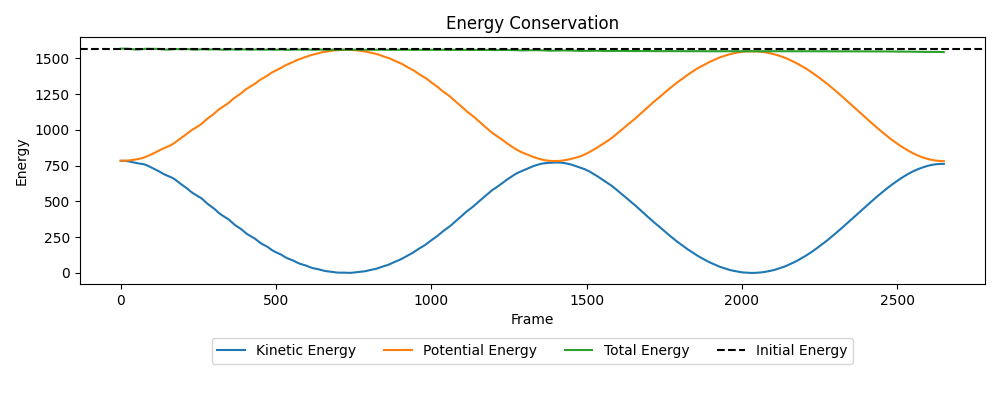

In [15]:
fig, axis = plt.subplots(1,1, figsize = (10,4), squeeze=False)

axis[0,0].plot(KEs, label = 'Kinetic Energy')
axis[0,0].plot(PEs, label = 'Potential Energy')
axis[0,0].plot(np.array(KEs) + np.array(PEs), label = 'Total Energy')
axis[0,0].axhline(KEs[0] + PEs[0], color = 'k', linestyle = '--', label = 'Initial Energy')
axis[0,0].set_xlabel('Frame')
axis[0,0].set_ylabel('Energy')
axis[0,0].set_title('Energy Conservation')

# Move the legend outside of the plot
axis[0,0].legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', ncol = 4)

fig.tight_layout()

In [ ]:
potentialEnergy = 0.5 * B**2 * (torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2)

In [56]:
r2 = torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2
v2 = torch.linalg.norm(initialVelocity, dim = -1)**2

dr = torch.linalg.norm(particleState['fluidPositions'], dim = -1) - torch.linalg.norm(perennialState['fluidPositions'], dim = -1)
dv = torch.linalg.norm(initialVelocity, dim = -1) - torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)

print(r2, v2)

print(perennialState['fluidMasses'])

print(dr, dv)
print(dr / dv)

tensor([0.3226, 0.3143, 0.3067,  ..., 0.3066, 0.3140, 0.3225], device='cuda:0') tensor([0.9982, 0.9957, 0.9933,  ..., 0.9933, 0.9957, 0.9982], device='cuda:0')
tensor([0.0990, 0.0990, 0.0990,  ..., 0.0990, 0.0990, 0.0990], device='cuda:0')
tensor([0.4311, 0.4372, 0.4429,  ..., 0.4429, 0.4375, 0.4312], device='cuda:0') tensor([0.9509, 0.9496, 0.9482,  ..., 0.9482, 0.9495, 0.9508], device='cuda:0')
tensor([0.4534, 0.4604, 0.4670,  ..., 0.4671, 0.4607, 0.4535], device='cuda:0')


In [81]:
Omega = 1
delta = 1


A = (torch.max(particleState['fluidPositions'][:,0]) - torch.min(particleState['fluidPositions'][:,0]) + config['particle']['dx']) / 2
B = (torch.max(particleState['fluidPositions'][:,1]) - torch.min(particleState['fluidPositions'][:,1]) + config['particle']['dx']) / 2

A_current = (torch.max(perennialState['fluidPositions'][:,0]) - torch.min(perennialState['fluidPositions'][:,0])) / 2
B_current = (torch.max(perennialState['fluidPositions'][:,1]) - torch.min(perennialState['fluidPositions'][:,1])) / 2

print(A, B)
print(A_current, B_current)

tensor(0.9950, device='cuda:0') tensor(0.9950, device='cuda:0')
tensor(1.8919, device='cuda:0') tensor(0.5162, device='cuda:0')


In [87]:
E_k = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(initialVelocity, dim = -1)**2
E_p = 0.5 * B**2 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(particleState['fluidPositions'], dim = -1)**2
print(E_k.sum().cpu().item())
print(E_p.sum().cpu().item())

784.545654296875
776.7586059570312


In [88]:
E_k = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2
E_p = 0.5 * B**2 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2
print(E_k.sum().cpu().item())
print(E_p.sum().cpu().item())

1.4952871799468994
1527.4677734375


In [83]:
np.pi * A * B

tensor(3.1104, device='cuda:0')

In [84]:
torch.sum(perennialState['fluidAreas'])

tensor(3.1385, device='cuda:0')

In [85]:
E_k = np.pi / 8 * config['fluid']['rho0'] * delta**2 * A * B * (A**2 + B**2)
E_p = np.pi / 8 * config['fluid']['rho0'] * Omega**2 * A * B * (A**2 + B**2)

print(E_k, E_p)

tensor(769.8846, device='cuda:0') tensor(769.8846, device='cuda:0')


In [69]:
E_k = np.pi / 8 * config['fluid']['rho0'] * delta**2 * A_current * B_current * (A_current**2 + B_current**2)
E_p = np.pi / 8 * config['fluid']['rho0'] * Omega**2 * A_current * B_current * (A_current**2 + B_current**2)

print(E_k, E_p)

tensor(23598.2480, device='cuda:0') tensor(23598.2480, device='cuda:0')


In [43]:
initialVelocity = perennialState['fluidVelocities'].clone()
initialVelocity[:,0] =  A * particleState['fluidPositions'][:,0]
initialVelocity[:,1] = -A * particleState['fluidPositions'][:,1]

initialKineticEnergy = 0.5 * particleState['fluidMasses'] * (torch.linalg.norm(initialVelocity, dim = -1)**2)
initialPotentialEnergy = particleState['fluidMasses'] * B * (torch.linalg.norm(particleState['fluidPositions'], dim = -1))


kineticEnergy = 0.5 * perennialState['fluidMasses'] * (torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2)
potentialEnergy = perennialState['fluidMasses'] * B * (torch.linalg.norm(perennialState['fluidPositions'], dim = -1))

totalInitialEnergy = initialKineticEnergy.sum() + initialPotentialEnergy.sum()
totalEnergy = kineticEnergy.sum() + potentialEnergy.sum()

print(f'Initial Energy: {totalInitialEnergy:.6g} (KE: {initialKineticEnergy.sum():.6g}, PE: {initialPotentialEnergy.sum():.6g})')
print(f'Final Energy: {totalEnergy:.6g} (KE: {kineticEnergy.sum():.6g}, PE: {potentialEnergy.sum():.6g})')
print(f'Energy difference: {totalEnergy - totalInitialEnergy:.3g} ({(totalEnergy - totalInitialEnergy) / totalInitialEnergy * 100:.3g}%)')

Initial Energy: 774.496 (KE: 154.839, PE: 619.657)
Final Energy: 774.496 (KE: 154.839, PE: 619.657)
Energy difference: 0 (0%)


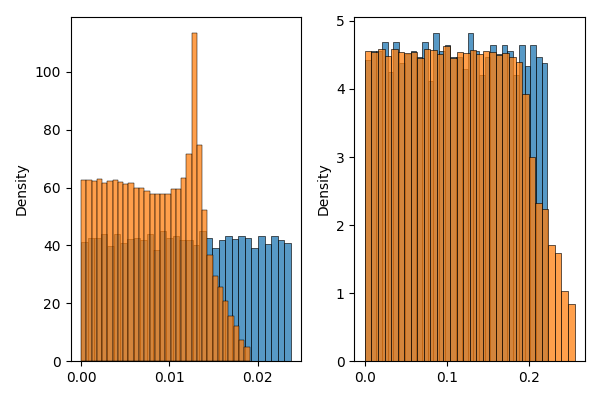

In [30]:
import seaborn as sns


fig, axis = plt.subplots(1,2, figsize = (6,4), squeeze=False)

sns.histplot(initialPotentialEnergy.cpu().numpy(), ax = axis[0,1], kde = False, stat = 'density', bins = nx//4)
sns.histplot(potentialEnergy.cpu().numpy(), ax = axis[0,1], kde = False, stat = 'density', bins = nx//4)


sns.histplot(initialKineticEnergy.cpu().numpy(), ax = axis[0,0], kde = False, stat = 'density', bins = nx//4)
sns.histplot(kineticEnergy.cpu().numpy(), ax = axis[0,0], kde = False, stat = 'density', bins = nx//4)



fig.tight_layout()

<img src = "./squarePatch.gif" width = 500/>